<a href="https://colab.research.google.com/github/paciello1899922/CrowdCounting/blob/main/Crowd_Counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
from google.colab import drive
from google.colab.patches import cv2_imshow
from skimage import io

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, ConcatDataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from skimage import io, transform

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    


In [ ]:

!unzip /content/drive/MyDrive/DatasetCrowd/jhu_crowd_v2.0.zip


In [68]:
annotations = pd.read_csv('/content/jhu_crowd_v2.0/train/image_labels.txt', header=None)
img_name = (annotations.loc[0,0])
img_name


1

In [140]:

class CrowdsDataset(Dataset):

  def __init__(self, txt_file, path, heads_path, transform=None):
    self.annotations = pd.read_csv(txt_file, header=None)
    self.path = path
    self.heads_path = heads_path
    self.transform = transform

    self.heads_dimensions = 0
    i = 0
    self.heads = []
    for filename in sorted(os.listdir(heads_path),key=str.lower):
      
      
      
      f = os.path.join(heads_path, filename)
      if os.stat(f).st_size!=0:
        heads_annotations = pd.read_csv(f, delimiter=' ', header=None)
        self.heads_dimensions += len(heads_annotations)
        self.heads.append(np.asarray(heads_annotations.iloc[0:, 0:])) 
      else:
        m = np.array([])
        self.heads.append(m)
      
      i+=1
    self.heads = np.asarray(self.heads)
   
    
    
  
    
  
  def __len__(self):
    return len(self.annotations) + self.heads_dimensions #aggiungere 

  def __getitem__(self,index):
    if torch.is_tensor(index):
      index = index.tolist()
    img_name = os.path.join(self.path, str(self.annotations.loc[index,0]).zfill(4)) + '.jpg'
    image = io.imread(img_name)
    total_people = self.annotations.iloc[index,1]
    scene_type = self.annotations.iloc[index,2]
    weather_conditions = self.annotations.iloc[index,3]
    distractor = self.annotations.iloc[index,4]
    heads_locations = self.heads[index]
   
    sample = {'image': image, 'total_people': total_people, 'scene_type': scene_type, 'weather_conditions': weather_conditions, 'distractor': distractor, 'heads_locations': heads_locations}

    if self.transform :
        sample = self.Transform(sample)
    
    return sample




In [187]:
def show_heads(image,heads):
  plt.imshow(image)
  if heads.size!=0:
    plt.scatter(heads[:,0], heads[:,1], s=10, marker='.', c='r')



In [181]:
crowd_dataset = CrowdsDataset(txt_file = '/content/jhu_crowd_v2.0/train/image_labels.txt', path = '/content/jhu_crowd_v2.0/train/images/', heads_path = '/content/jhu_crowd_v2.0/train/gt/')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0 (513, 730, 3) 161 (161, 6)


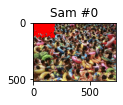

1 (630, 1200, 3) 855 (855, 6)


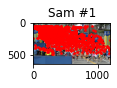

2 (1573, 2048, 3) 455 (455, 6)


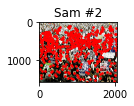

3 (2232, 3348, 3) 7139 (7139, 6)


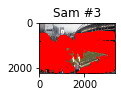

[]


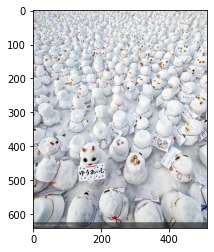

In [161]:

fig = plt.figure()

for i in range (len(crowd_dataset)):
  sample = crowd_dataset[i]

  print(i, sample['image'].shape, sample['total_people'], sample['heads_locations'].shape)
  ax = plt.subplot(1, 4, i + 1)
  plt.tight_layout()
  ax.set_title ('Sam #{}'.format(i))
  show_heads(sample['image'], sample['heads_locations'])

  if i==3:
    plt.show()
    break

sample = crowd_dataset[777]
print(sample['heads_locations'])
show_heads(sample['image'], sample['heads_locations'])

In [180]:
import random
class Rescale(object):
  def __init__(self,output_size):
    assert isinstance(output_size, (int, tuple))
    self.output_size = output_size
  
  def __call__(self,sample):
    image = sample['image']
    heads_locations = np.zeros((len(sample['heads_locations']),6))
    h, w = image.shape[:2]
    if isinstance(self.output_size, int):
      if h > w:
        new_h, new_w = self.output_size * h / w, self.output_size
      else:
        new_h, new_w = self.output_size, self.output_size * w / h
    else:
        new_h, new_w = self.output_size

    new_h, new_w = int(new_h), int(new_w)

    img = transform.resize(image, (new_h, new_w))
    #if heads_locations.size>0:
     # heads_locations[:,0] = heads_locations[:,0] * new_w/w
      #heads_locations[:,1] = heads_locations[:,1] * new_h/h
    for i in range(sample['heads_locations'].shape[0]):
      heads_locations[i,0] = sample['heads_locations'][i,0] * new_w/w
      heads_locations[i,1] = sample['heads_locations'][i,1] * new_h/h
      heads_locations[i,2] = sample['heads_locations'][i,2]
      heads_locations[i,3] = sample['heads_locations'][i,3]
      heads_locations[i,4] = sample['heads_locations'][i,4]
      heads_locations[i,5] = sample['heads_locations'][i,5]

    
    return {'image': img, 'heads_locations': heads_locations}


class RandomCrop(object):
   
   def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = output_size
        else:
            assert len(output_size) == 2
            self.output_size = (output_size, output_size)

   def __call__(self, sample):
        image = sample['image']
        heads_locations = np.zeros((len(sample['heads_locations']),6))
        
        h, w = image.shape[:2]
        new_h = self.output_size
        new_w = self.output_size

        top = random.randint(0, h - new_h)
        left = random.randint(0, w - new_w)
        print(top,left)
        image = image[top: top + new_h,
                      left: left + new_w]

        
        for i in range(sample['heads_locations'].shape[0]):
          if (sample['heads_locations'][i,0]>=left) and (sample['heads_locations'][i,1]>=top) and (sample['heads_locations'][i,0]<=left+self.output_size) and (sample['heads_locations'][i,1]<=top+self.output_size):
            heads_locations[i,0] = sample['heads_locations'][i,0] - left
            heads_locations[i,1] = sample['heads_locations'][i,1] - top
            heads_locations[i,2] = sample['heads_locations'][i,2]
            heads_locations[i,3] = sample['heads_locations'][i,3]
            heads_locations[i,4] = sample['heads_locations'][i,4]
            heads_locations[i,5] = sample['heads_locations'][i,5]

        heads_locations = heads_locations[~np.all(heads_locations == 0, axis=1)]          
        

        return {'image': image, 'heads_locations': heads_locations}
    

class ToTensor(object):
  def __call__(self, sample):
        image, heads_locations = sample['image'], sample['heads_locations']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'heads_locations': torch.from_numpy(heads_locations)}





512 1762
[[74. 55. 75. 73.  1.  0.]
 [13. 33. 75. 73.  1.  0.]
 [91. 12. 75. 73.  1.  0.]]
<class 'numpy.ndarray'>
Compose(
)
21 168
[[ 42.95454545  37.15359741  31.          38.           1.
    0.        ]
 [163.73636364  71.50767987  75.          73.           1.
    0.        ]
 [ 23.72045455  37.98140663  31.          38.           1.
    0.        ]
 ...
 [161.66818182  59.29749394  31.          38.           1.
    0.        ]
 [ 77.07954545  16.87227162  10.          12.           1.
    0.        ]
 [109.55        29.08245756  31.          38.           1.
    0.        ]]
<class 'numpy.ndarray'>


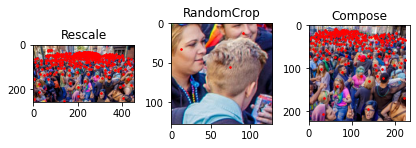

In [191]:


scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

fig = plt.figure()
sample = crowd_dataset[745]
for i, tsfrm in enumerate([scale, crop, composed]):
  print(tsfrm)
  transformed_sample = tsfrm(sample)
  ax = plt.subplot(1, 3, i + 1)
  plt.tight_layout()
  ax.set_title(type(tsfrm).__name__)
  show_heads(transformed_sample['image'], transformed_sample['heads_locations'])

plt.show()